# HarvestStat Data Profiling - Chad

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Chad'
country_iso2 = 'TD'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32633' # Chad
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_TD.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([TD_Admin1_1960, TD_Admin1_2008, TD_Admin1_2012], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 9,647
Removed 120 "Missing Value" points
3,120/3,126 "Area Harvested" points are retained.
3,093/3,126 "Quantity Produced" points are retained.
3,314/3,395 "Yield" points are retained.
Current data points: 9,527



- Minor changes are applied ------------------- #

- Basic information --------------------------- #


Data period: 1983 - 2017
13 grain types are found: Bambara groundnut, Cassava, Cowpeas (Mixed), Fonio, Groundnuts (In Shell), Maize (Corn), Millet, Rice (Paddy), Sesame Seed, Sorghum, Sweet Potatoes, Taro, move to 1594AA, Wheat Grain
2 seasons are found: Main harvest (10-01), Cold off-season harvest (02-01)
1 crop production system are found: none
Data sources include:
[1] Ministry of Agriculture and Irrigation, Chad --- Resultats Definitifs De La Campagne Agricole, Chad
Administrative-1 fnids: 49
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over time ------------------ #
season_name           Cold off-season harvest Main harvest
                                                          
Bambara groundnut                        0.0%         0.5%
Cassava                                  0.0%         7.2%
Cowpeas (Mixed)                          0.0%         2.3%
Fonio                                    0.0%         0.0%
Groundnuts (In Shell)               

----------------------------------------------- #
Crop type: Bambara groundnut
----------------------------------------------- #
season_name            Main harvest              
crop_production_system         none              
fnid_short                   1960A1 2008A1 2012A1
year                                             
1996                           5/14    NaN    NaN
1997                           6/14    NaN    NaN
1998                           5/14    NaN    NaN
1999                            NaN    NaN    NaN
2000                          10/14    NaN    NaN
2001                           8/14    NaN    NaN
2002                            NaN    NaN    NaN
2003                           8/14    NaN    NaN
2004                           8/14    NaN    NaN
2005                           1/14    NaN    NaN
2006                            NaN    NaN    NaN
2007                            NaN    NaN    NaN
2008                           1/14    NaN    NaN
2009                 

../figures/TD_admin_shapes.png is saved.



- Chad crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-chad.png?itok=IYemQBC5"  width=900>

- FDW data consists of `TD1960A1`, `TD2008A1`, and `TD2012A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1960 | TD1960A1| 14        | TD1960A2 | 52     |
| 2008 | TD2008A1| 22        | TD2008A2 | 62     |
| 2012 | **`TD2012A1`**| 23 | TD2012A2 | 68    |

- Comparison between admin boundaries.

<img src="../figures/TD_admin_shapes.png"  width=900>

- In 2008, 8 districts are divided and added.

| 1960-2008 |2008-2012|
| :---:|:---:|
|TD1960A124 (Chari-Baguirmi) | TD2008A104 (Chari-Baguirmi), TD2008A108 (Hadjer-Lamis), TD2008A117 (N'Djamena) |
|TD1960A125 (Kanem) | TD2008A109 (Kanem), TD2008A101 (Barh el Gazel)|
|TD1960A126 (Moyen-Chari)| TD2008A116 (Moyen-Chari), TD2008A113 (Mandoul)|
|TD1960A127 (Ouaddai) | TD2008A118 (Ouaddai), TD2008A120 (Sila) | 
|TD1960A128 (B.E.T.) | TD2008A122 (Tibesti), TD2008A103 (Borkou), TD2008A130 (Ennedi)|
|TD1960A129 (Mayo-Kebbi) | TD2008A114 (Mayo-Kebbi Est), TD2008A115 (Mayo-Kebbi Ouest) |

- In 2012, 1 district is divided and added.

| 2008-2012| 2012-present |
| :---:|:---:|
|TD2008A130 (Ennedi) | TD2012A105 (Ennedi-Est), TD2012A106 (Ennedi-Ouest)|

- **`TD2012A1`** is used to represent current admin-level 1 crop data.
- Chad has two crop seasons: `Main harvest` and `Cold off-season`.
- Chad has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = TD_Admin1_2012.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
df['season_name'] = df['season_name'].replace({'Main harvest':'Main', 'Cold off-season harvest': 'Cold-off'})
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1960, over_1960 = FDW_PD_CreateAdminLink(TD_Admin1_1960, TD_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1960['TD1960A128'].update(method='PBR')
link_1960['TD1960A124'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1960.items()]) == 'PBR')
link_2008, over_2008 = FDW_PD_CreateAdminLink(TD_Admin1_2008, TD_Admin1_2012, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2008['TD2008A130'].update(method='PBR')
link_2008['TD2008A122'].update(method='PBR')
link_2008['TD2008A103'].update(method='PBR')
link_2008['TD2008A108'].update(method='PBR')
link_2008['TD2008A117'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_2008.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1960 = FDW_PD_RatioAdminLink(link_1960, prod, over_1960, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)
# Merge link_ratio
assert link_ratio_1960.keys() == link_ratio_2008.keys()
link_merged = [link_ratio_1960, link_ratio_2008]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

CBR is considered for 'TD1960A128' as no record found in: ['TD2012A103', 'TD2012A105', 'TD2012A106', 'TD2012A122']
CBR is considered for 'TD1960A124' as no record found in: ['TD2012A117']


CBR is considered for 'TD2008A130' as no record found in: ['TD2012A105', 'TD2012A106']
CBR is considered for 'TD2008A122' as no record found in: ['TD2012A122']
CBR is considered for 'TD2008A103' as no record found in: ['TD2012A103']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


## Postprocessing outlier removal

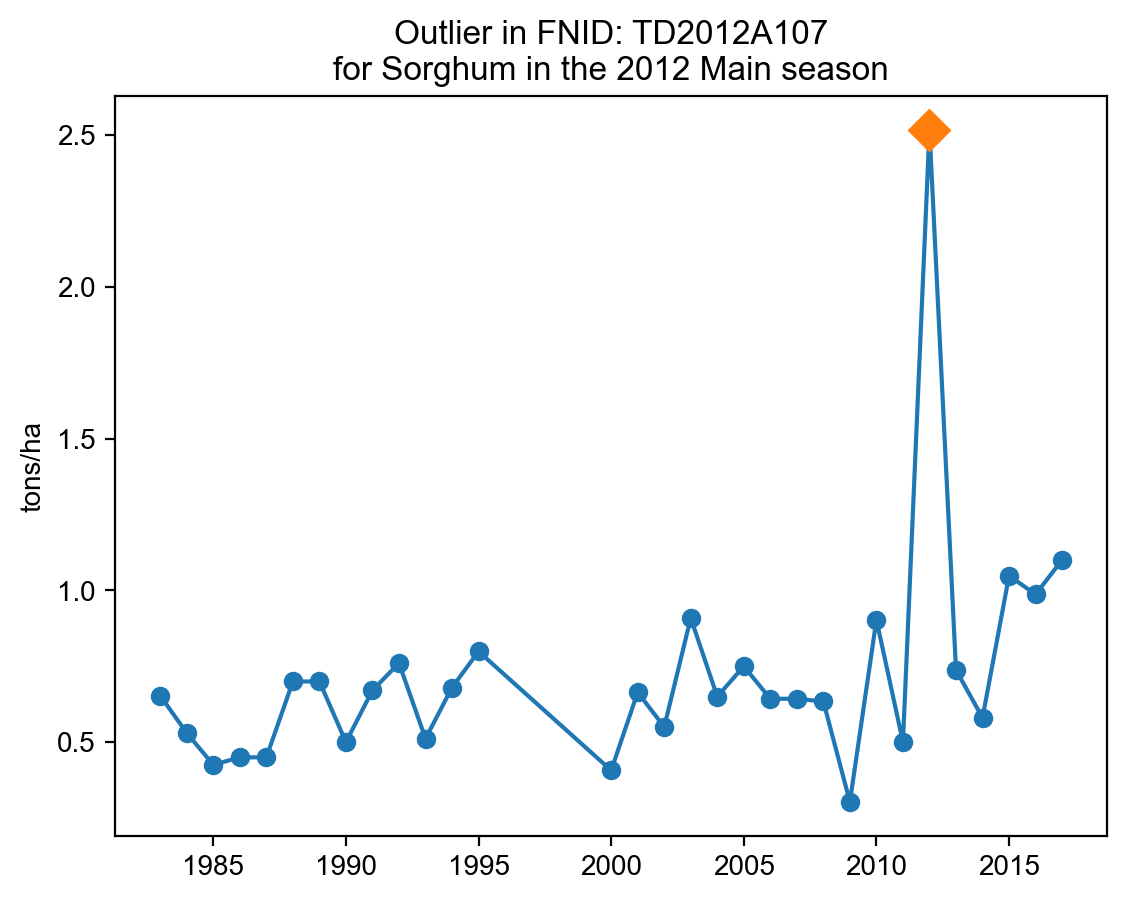

In [7]:
from matplotlib import pyplot as plt

outliers = [
    ['TD2012A107','Sorghum','Main',2012]
]
stack=stack.sort_values(by='harvest_year')

#first plot, then flag the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_TD.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_TD_ratio.npz', link_ratio)

../data/crop/adm_crop_production_TD.csv is saved.
../data/crop/adm_crop_production_TD_ratio.npz is saved.


## Visualization of production data

/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


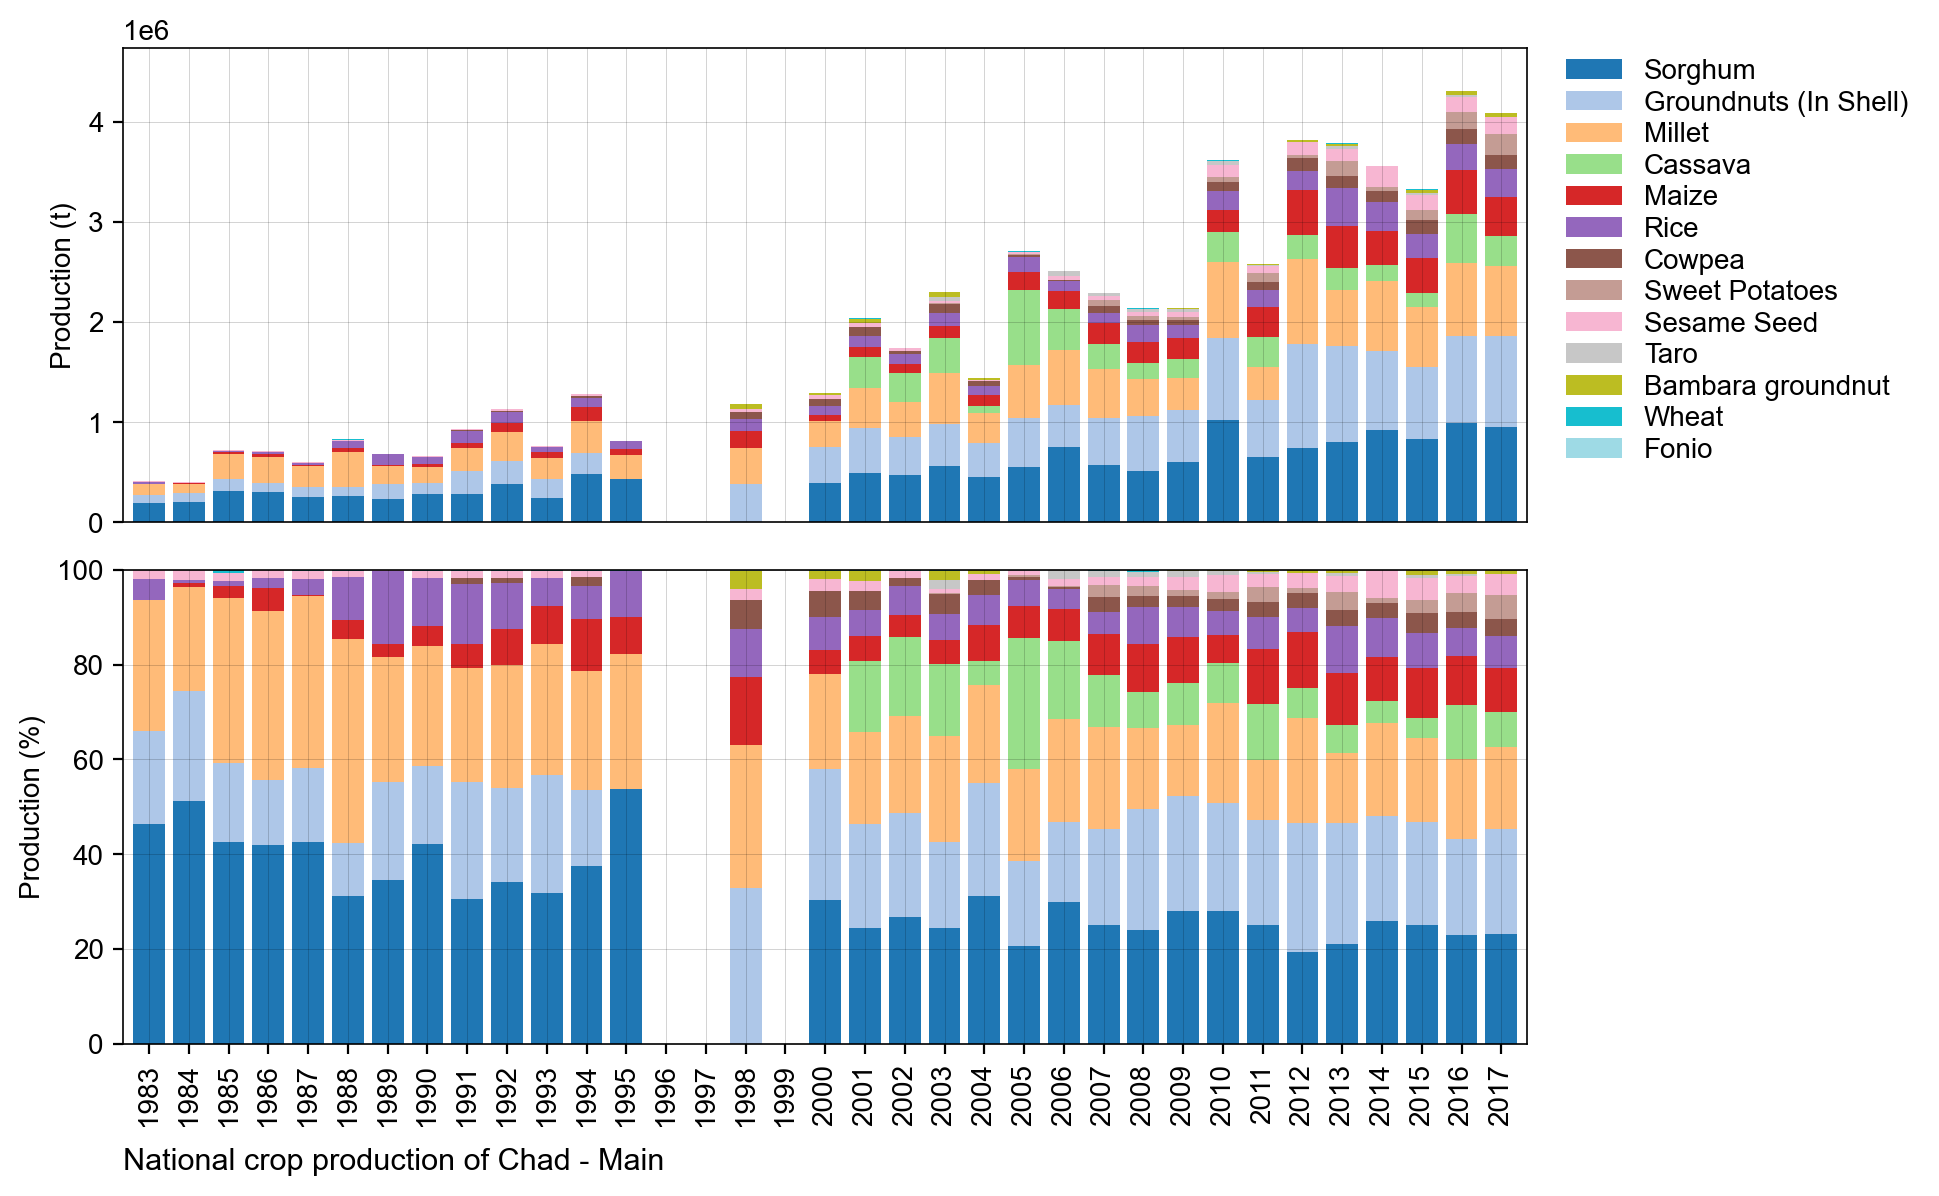

../figures/TD_bar_natgrainprod_Main.png is saved.


/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


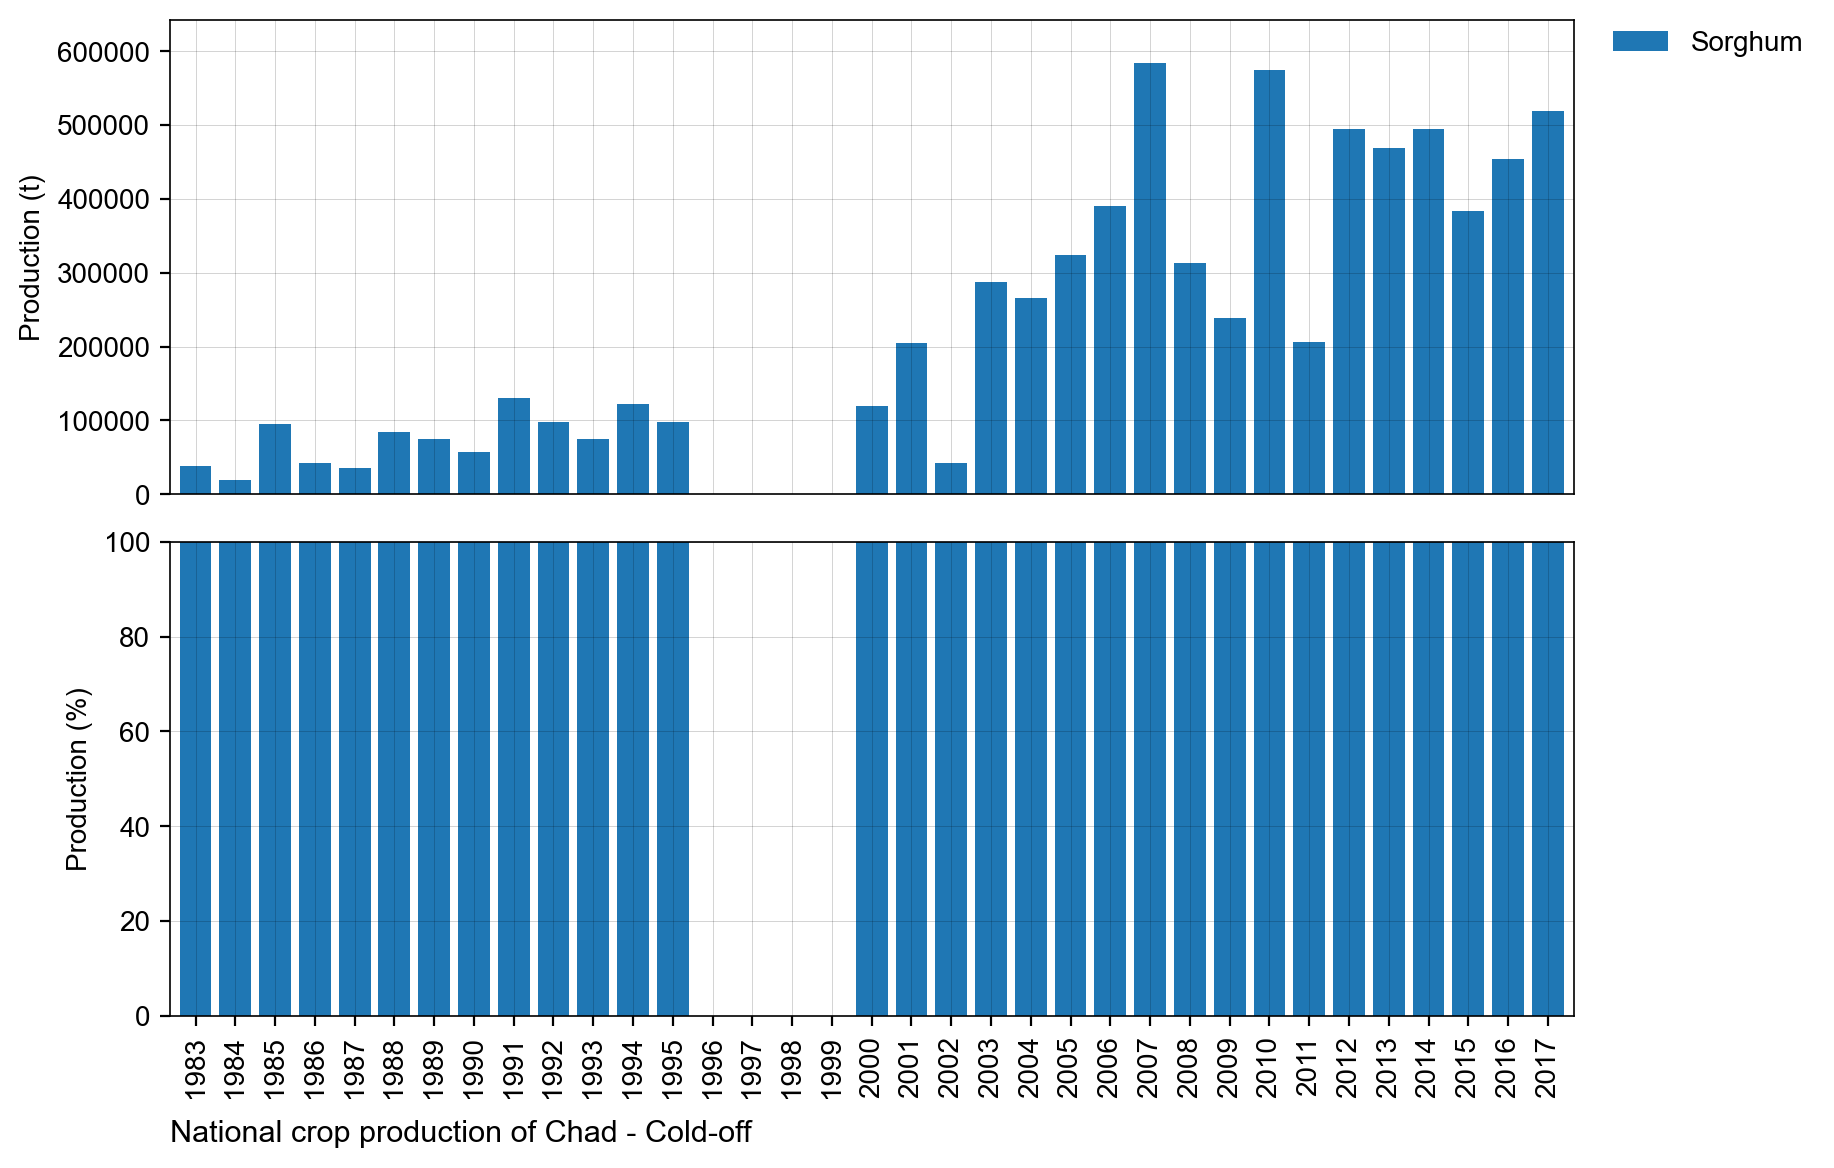

../figures/TD_bar_natgrainprod_Cold-off.png is saved.


In [9]:
# Bar chart of national grain production
country_iso, country_name = 'TD', 'Chad'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main','Cold-off']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

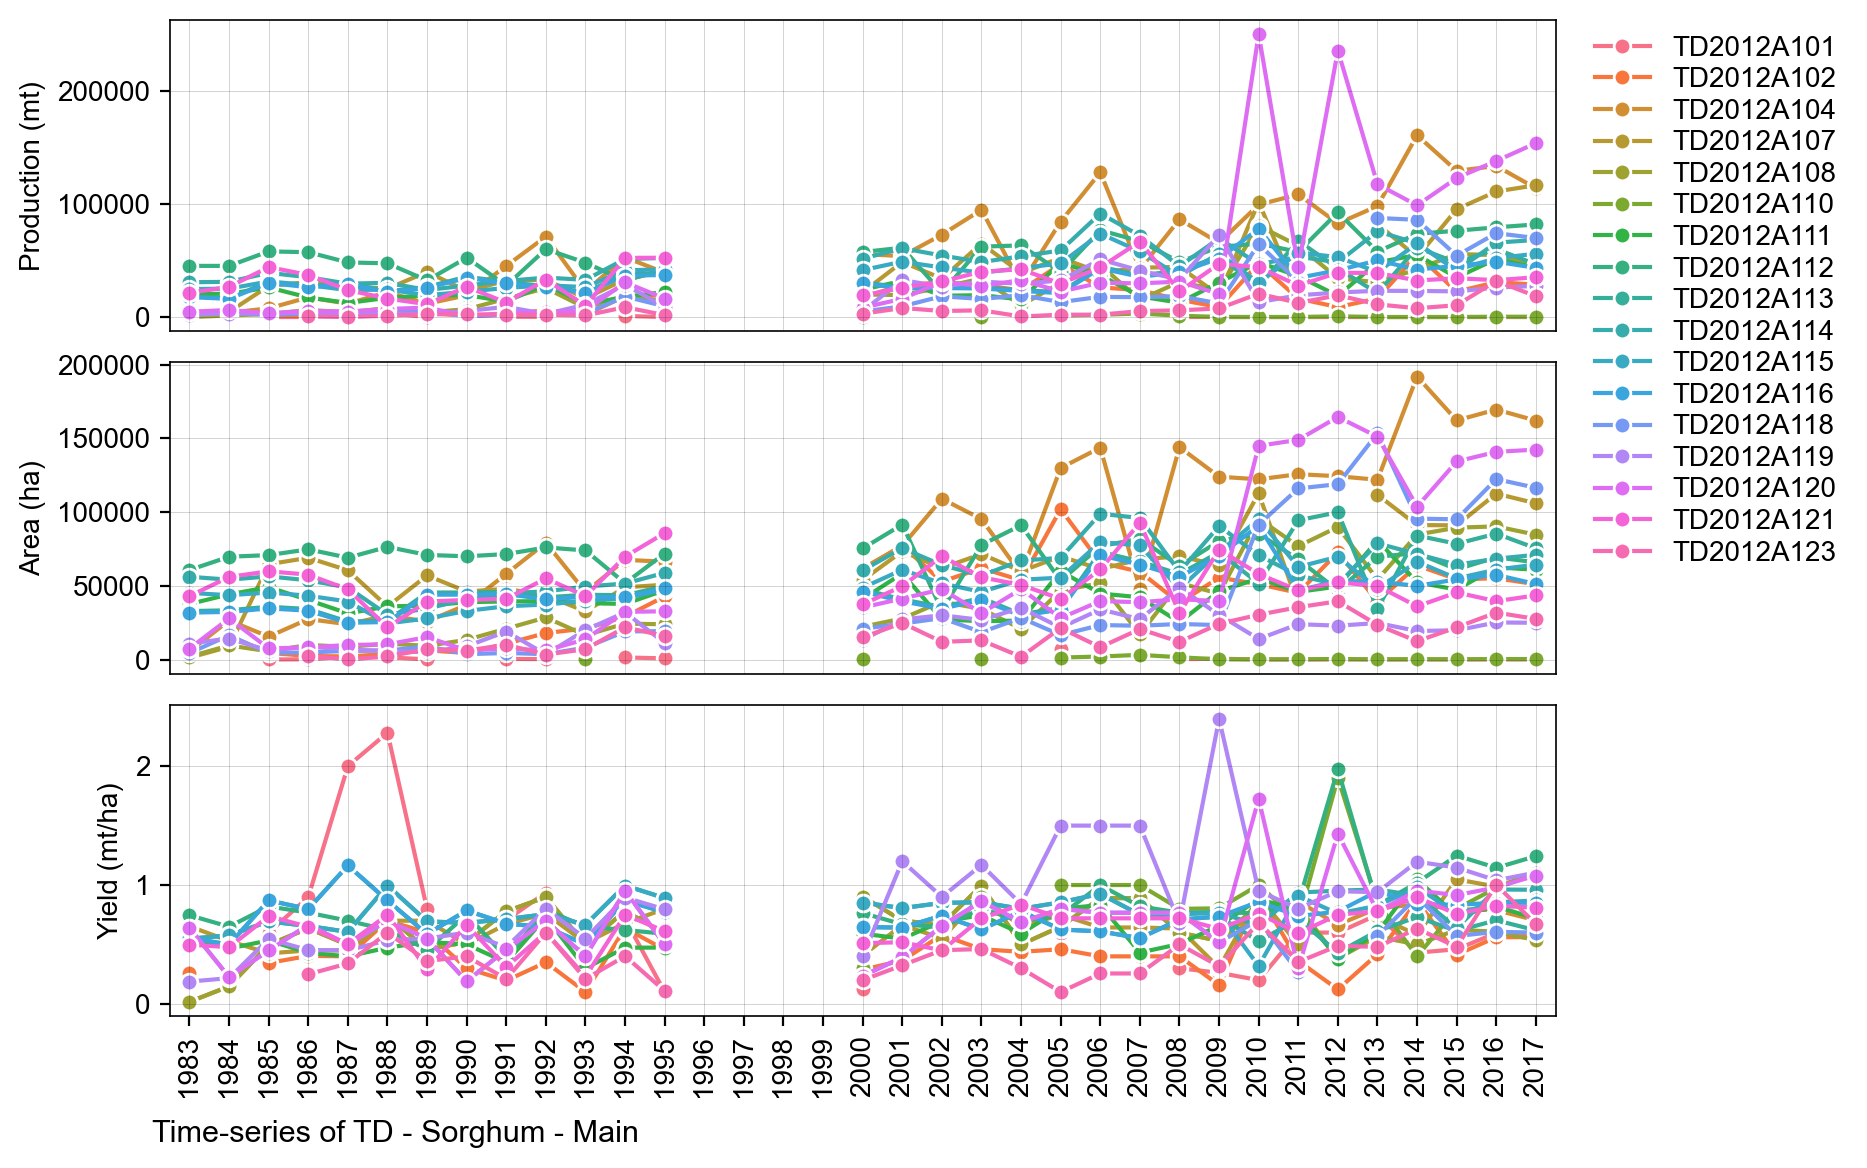

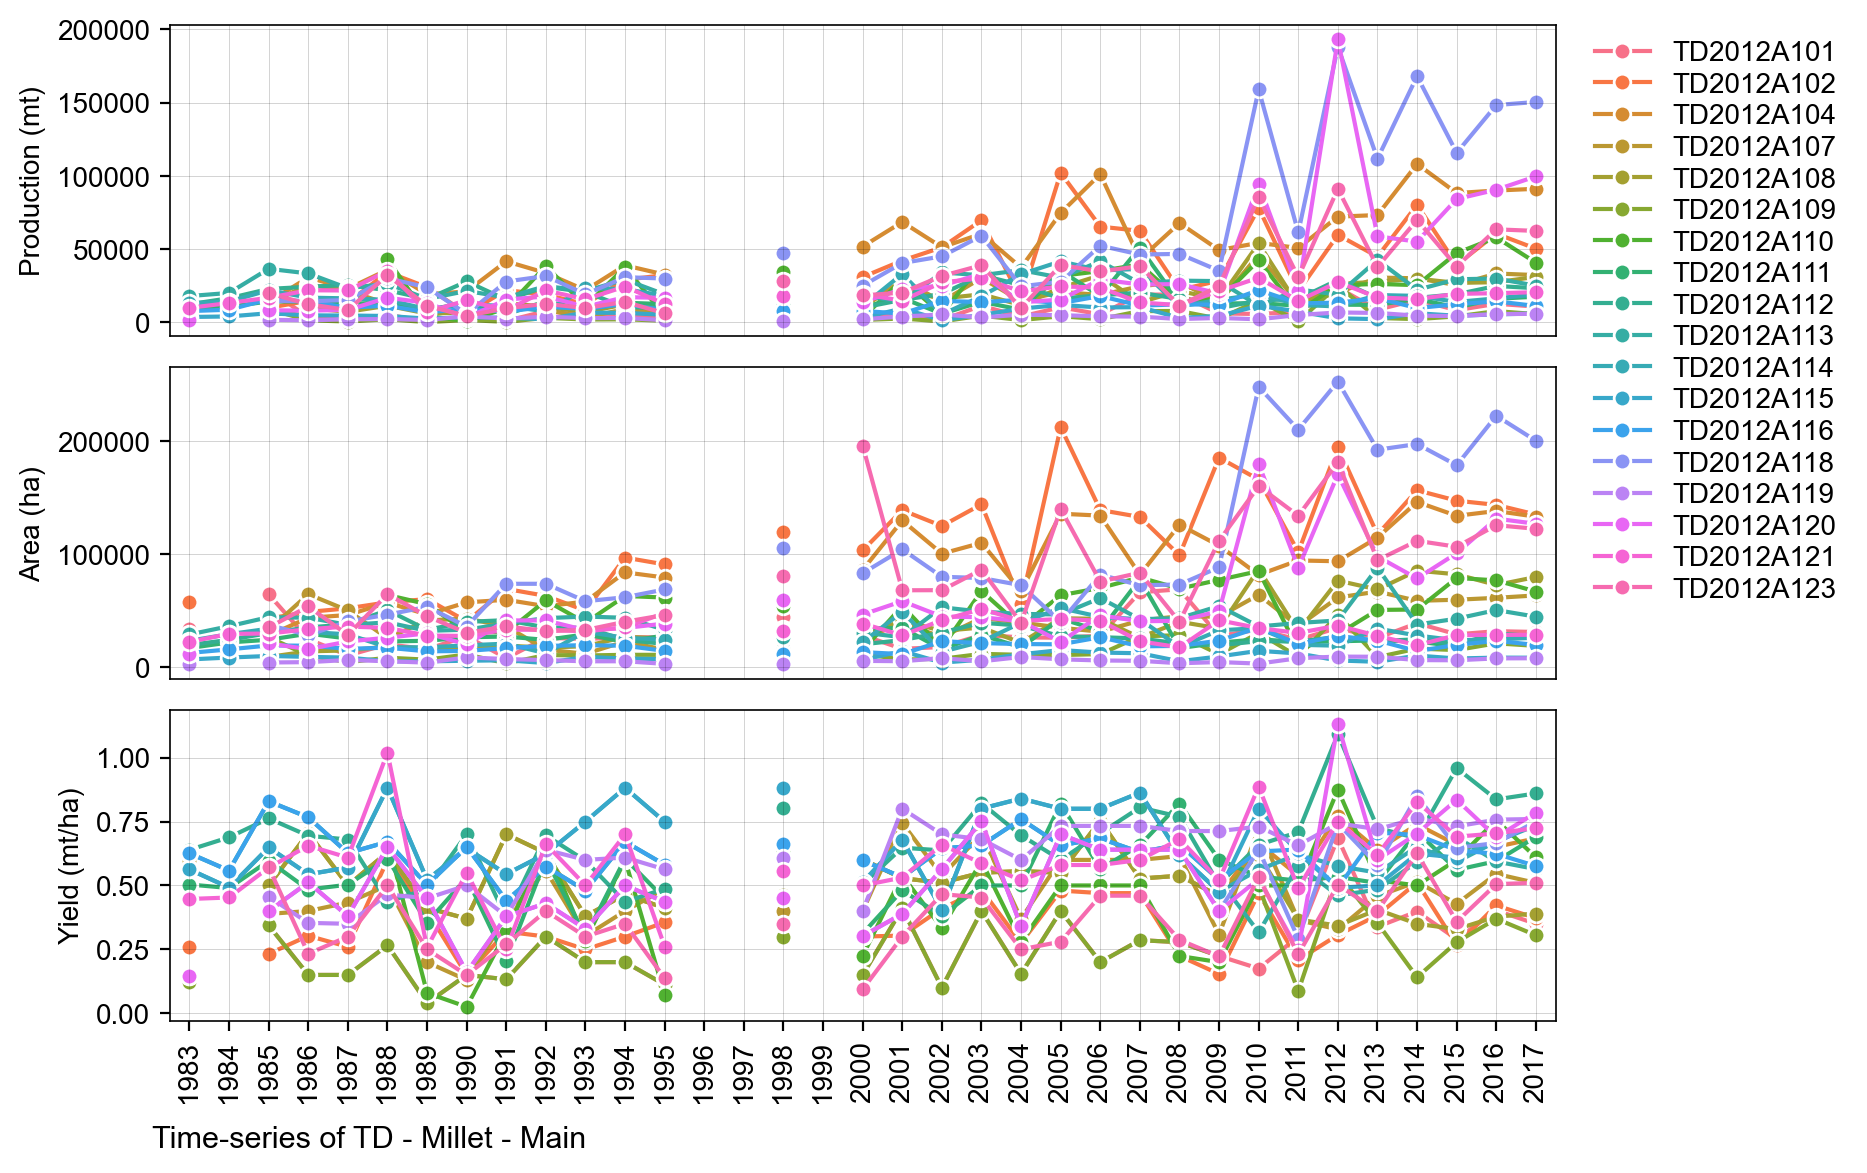

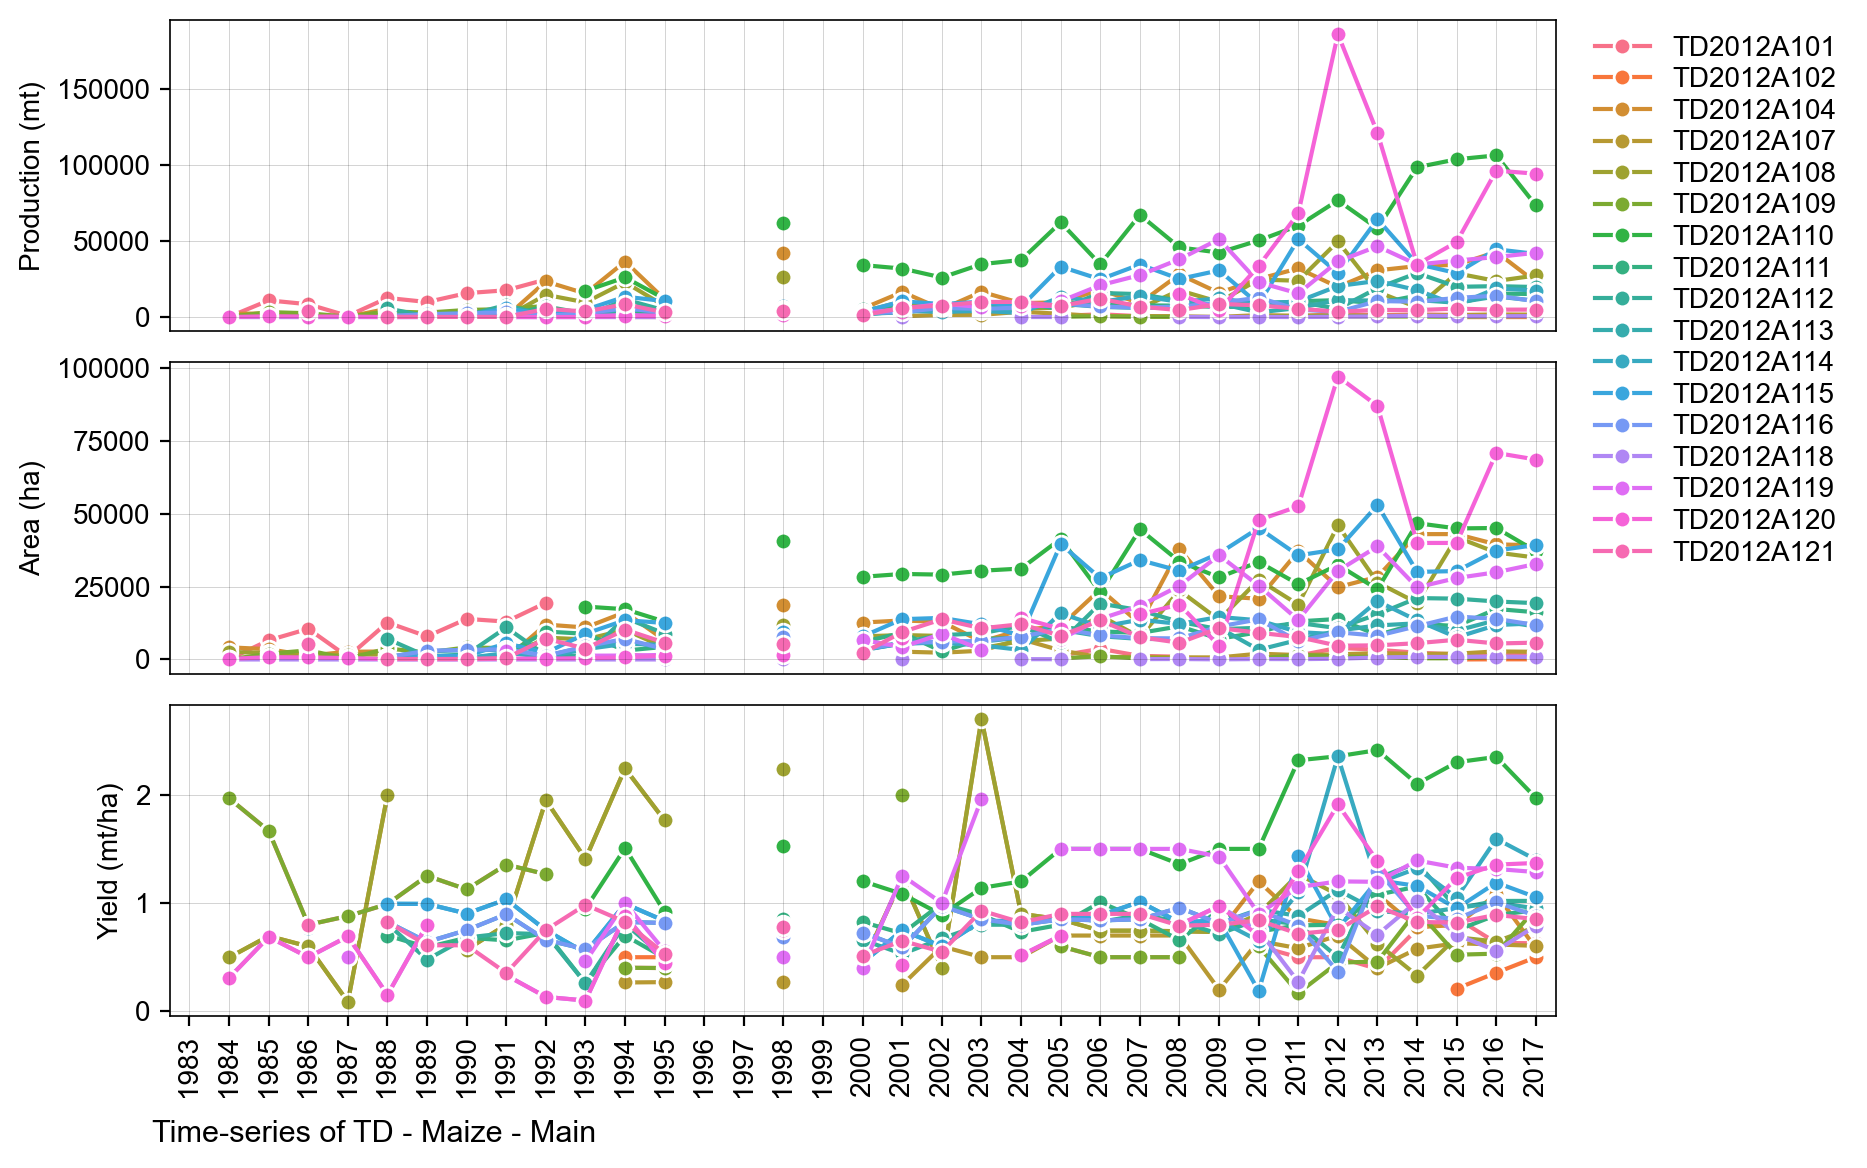

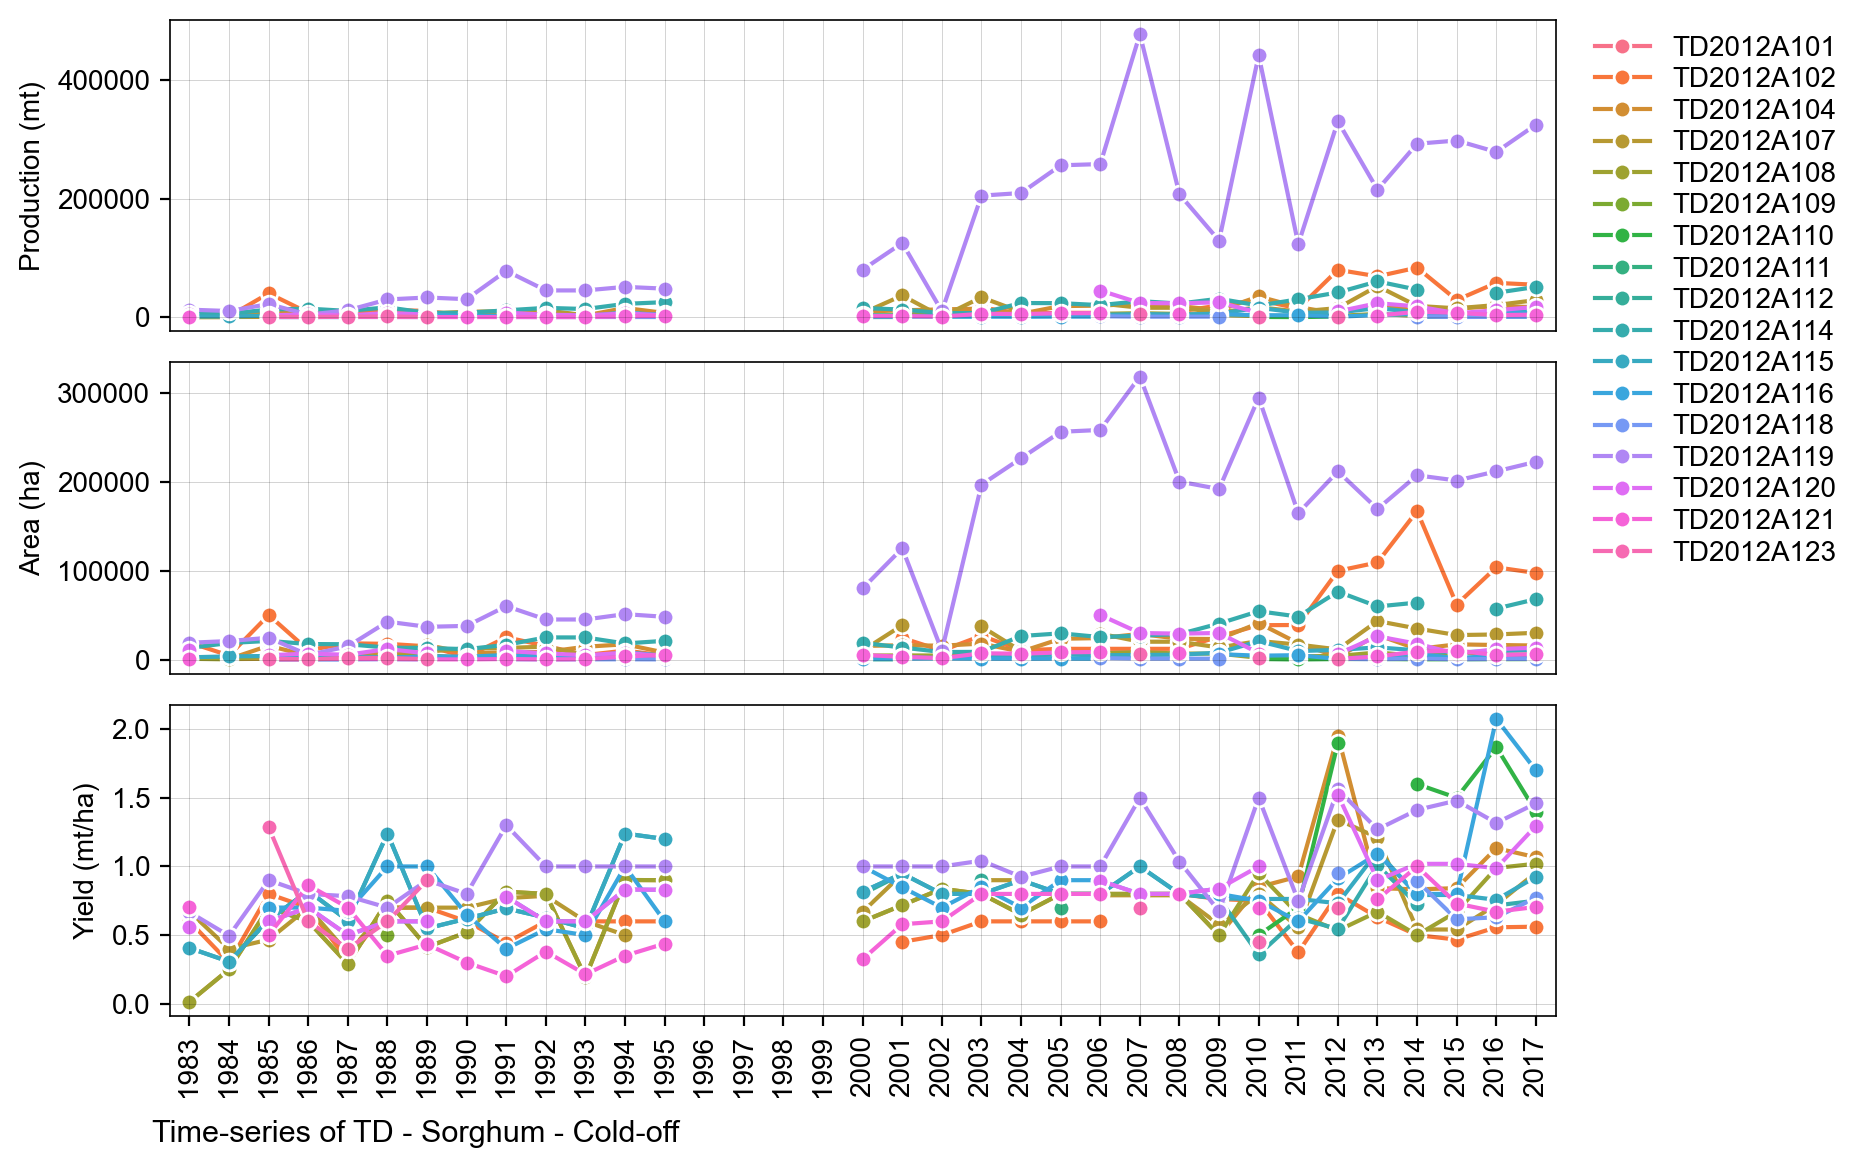

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'TD', 'Chad'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Sorghum','Main'],
    ['Millet','Main'],
    ['Maize','Main'],
    ['Sorghum','Cold-off'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)